# Neural Nets for Digit Recognition

Import the data

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
# Load the dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]

Normalize data and split into train and test sets.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

X = X / 255.0
y = y.astype(np.int8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.142857, random_state=42)

Define activation functions, derivatives, and one-hot encoding.

In [3]:
# ReLU activation function
def relu(x):
    return np.maximum(0, x)

def relu_derivative(Z):
    return Z > 0

# SeLU activation function

def selu(x, alpha=1.75809, scale=1.0507):
    x_clipped = np.clip(x, -500, 500)  # Clip the values to prevent overflow (suggestion from ChatGPT)
    return scale * np.where(x_clipped >= 0.0, x_clipped, alpha * (np.exp(x_clipped) - 1))

def selu_derivative(x, alpha=1.75809, scale=1.0507):
    x_clipped = np.clip(x, -500, 500)  # Clip the values to prevent overflow (suggestion from ChatGPT)
    return scale * np.where(x_clipped >= 0.0, 1, alpha * np.exp(x_clipped))

# Tanh activation function

def tanh(x):
    return np.tanh(x)

def tanh_derivative(Z):
    return 1 - np.tanh(Z) ** 2

# Softmax activation

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtract max to stabilize
    return exps / np.sum(exps, axis=1, keepdims=True)

# One hot endocing
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

Define how the forward and backpropagation works. I added weights and biases as parameters for flexibility of the architecture, specifically for reusing for the demonstration of overfitting.

In [4]:
def forward_pass(X, weights, biases):
    activations = []
    z_list = []
    
    a = X
    # First layer: ReLU activation
    z = np.dot(a, weights[0]) + biases[0]
    a = relu(z)
    z_list.append(z)
    activations.append(a)
    
    # Second layer: SELU activation
    z = np.dot(a, weights[1]) + biases[1]
    a = selu(z)
    z_list.append(z)
    activations.append(a)
    
    # Third layer: Tanh activation
    z = np.dot(a, weights[2]) + biases[2]
    a = tanh(z)
    z_list.append(z)
    activations.append(a)
    
    # Output layer: Softmax activation
    z = np.dot(a, weights[-1]) + biases[-1]
    output = softmax(z)
    z_list.append(z)
    activations.append(output)

    return output, activations, z_list


def backward_pass(X, y_true, output, activations, z_list, weights):
    grad_weights = []
    grad_biases = []
    
    # Output layer: Derivative of Softmax (already handled with cross-entropy)
    delta = output - y_true
    grad_w = np.dot(activations[-2].T, delta)
    grad_b = np.sum(delta, axis=0)

    grad_weights.append(grad_w)
    grad_biases.append(grad_b)

    # Backpropagation through the Tanh layer
    delta = np.dot(delta, weights[-1].T) * tanh_derivative(z_list[-2])
    grad_w = np.dot(activations[-3].T, delta)
    grad_b = np.sum(delta, axis=0)
    grad_weights.insert(0, grad_w)
    grad_biases.insert(0, grad_b)
    
    # Backpropagation through the SELU layer
    delta = np.dot(delta, weights[-2].T) * selu_derivative(z_list[-3])
    grad_w = np.dot(activations[-4].T, delta)
    grad_b = np.sum(delta, axis=0)
    grad_weights.insert(0, grad_w)
    grad_biases.insert(0, grad_b)

    # Backpropagation through the ReLU layer
    delta = np.dot(delta, weights[-3].T) * relu_derivative(z_list[-4])
    grad_w = np.dot(X.T, delta)  # X is input to the first layer
    grad_b = np.sum(delta, axis=0)
    grad_weights.insert(0, grad_w)
    grad_biases.insert(0, grad_b)

    return grad_weights, grad_biases


Define the loss function and accuracy. ChatGPT created the categorical cross-entropy loss function and accuracy function.

In [5]:
# Categorical entropy loss
def categorical_crossentropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)
    n_samples = y_pred.shape[0]
    loss = -np.sum(y_true * np.log(y_pred)) / n_samples
    return loss

def zero_one_loss(y_true, y_pred):
    true_labels = np.argmax(y_true, axis=1)
    predicted_labels = np.argmax(y_pred, axis=1)
    misclassified = np.mean(predicted_labels != true_labels)
    return misclassified


Define how adam updates the parameters

In [6]:
def adam_update(param, gradient, first_moment, second_moment, time_step, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
    first_moment = beta1 * first_moment + (1 - beta1) * gradient
    second_moment = beta2 * second_moment + (1 - beta2) * (gradient ** 2)
    m_hat = first_moment / (1 - beta1 ** time_step)
    v_hat = second_moment / (1 - beta2 ** time_step)
    param -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
    return param, first_moment, second_moment

Another function for accuracy calculation (extracted away from the training loop)

In [7]:
def compute_accuracy(predictions, labels):
    predicted_labels = np.argmax(predictions, axis=1)  
    true_labels = np.argmax(labels, axis=1)  
    accuracy = np.mean(predicted_labels == true_labels) 
    return accuracy

Mini-batch SGD helper functions for initializing parameters, splitting data into mini-batches, and running the forward pass and getting the loss for each mini-batch.

In [8]:
def initialize_weights(input_size, hidden_sizes, output_size, init_method='he'):
    weights = []
    biases = []

    layer_sizes = [input_size] + hidden_sizes + [output_size]
    
    for i in range(len(layer_sizes) - 1):
        if init_method == 'he':
            weight = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / layer_sizes[i])
        elif init_method == 'xavier':
            weight = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(1 / layer_sizes[i])
        bias = np.zeros(layer_sizes[i+1])
        
        weights.append(weight)
        biases.append(bias)
    
    return weights, biases

def initialize_adam_params(weights, biases):
    first_moment_weights = [np.zeros_like(w) for w in weights]
    second_moment_weights = [np.zeros_like(w) for w in weights]
    first_moment_biases = [np.zeros_like(b) for b in biases]
    second_moment_biases = [np.zeros_like(b) for b in biases]
    return first_moment_weights, second_moment_weights, first_moment_biases, second_moment_biases


def get_mini_batches(X, y, batch_size):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X_shuffled = X.iloc[indices]
    y_shuffled = y.iloc[indices]
    
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        yield X_shuffled[start_idx:end_idx], y_shuffled[start_idx:end_idx]

def forward_pass_and_loss(X, y, weights, biases):
    output, activations, z_list = forward_pass(X, weights, biases)
    y_one_hot = one_hot_encode(y)
    loss = categorical_crossentropy(y_one_hot, output)
    accuracy = compute_accuracy(output, y_one_hot)
    return loss, accuracy, output, activations, z_list

The training loop that runs the forward pass, backpropagation, and updates the parameters using adam.

In [9]:
from matplotlib import pyplot as plt

def mini_batch_sgd(X_train, y_train, X_test, y_test, weights, biases, batch_size, learning_rate, epochs):
    first_moment_weights, second_moment_weights, first_moment_biases, second_moment_biases = initialize_adam_params(weights, biases)
    
    n_samples = X_train.shape[0]
    adam_time_step = 0 

    train_losses = [] 
    val_losses = []
    train_accuracies = [] 
    val_accuracies = []

    for epoch in range(epochs):
        epoch_loss = 0
        correct_predictions = 0

        # Loop over mini-batches
        for X_batch, y_batch in get_mini_batches(X_train, y_train, batch_size):
            adam_time_step += 1

            y_batch_one_hot = one_hot_encode(y_batch)

            # Forward pass and loss for the batch
            loss, accuracy, output, activations, z_list = forward_pass_and_loss(X_batch, y_batch, weights, biases)
            epoch_loss += loss
            correct_predictions += accuracy * len(y_batch)

            # Backpropagation in action
            grad_weights, grad_biases = backward_pass(X_batch, y_batch_one_hot, output, activations, z_list, weights)

            # Update for weights and biases for the ADAM optimizer
            for i in range(len(weights)):
                weights[i], first_moment_weights[i], second_moment_weights[i] = adam_update(weights[i], grad_weights[i], first_moment_weights[i], second_moment_weights[i], adam_time_step, learning_rate)
                biases[i], first_moment_biases[i], second_moment_biases[i] = adam_update(biases[i], grad_biases[i], first_moment_biases[i], second_moment_biases[i], adam_time_step, learning_rate)

        # Compute the epoch's metrics
        epoch_loss /= (n_samples / batch_size)
        epoch_accuracy = correct_predictions / n_samples

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation loss and accuracy
        val_loss, val_accuracy, _, _, _ = forward_pass_and_loss(X_test, y_test, weights, biases)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy*100:.2f}%, "
              f"Val Loss: {val_loss}, Val Accuracy: {val_accuracy*100:.2f}%")

    # Zero-One Loss after final epoch
    final_val_accuracy = val_accuracies[-1]
    zero_one_loss_value = 1 - final_val_accuracy
    print(f"Zero-One Loss on the test/validation set: {zero_one_loss_value}")

    # Plot training and validation loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


Epoch 1/10, Train Loss: 0.3253200929870144, Train Accuracy: 91.52%, Val Loss: 0.15887747327154206, Val Accuracy: 95.48%
Epoch 2/10, Train Loss: 0.11222461514466202, Train Accuracy: 96.69%, Val Loss: 0.1141068918905253, Val Accuracy: 96.59%
Epoch 3/10, Train Loss: 0.07736428161517814, Train Accuracy: 97.72%, Val Loss: 0.1169444425439926, Val Accuracy: 96.46%
Epoch 4/10, Train Loss: 0.05753468899404036, Train Accuracy: 98.27%, Val Loss: 0.09257704155710196, Val Accuracy: 97.03%
Epoch 5/10, Train Loss: 0.0455236106474287, Train Accuracy: 98.62%, Val Loss: 0.0935018662967543, Val Accuracy: 97.43%
Epoch 6/10, Train Loss: 0.036108623492565405, Train Accuracy: 98.91%, Val Loss: 0.09393552587181678, Val Accuracy: 97.34%
Epoch 7/10, Train Loss: 0.029287245342126726, Train Accuracy: 99.07%, Val Loss: 0.09846555671153463, Val Accuracy: 97.28%
Epoch 8/10, Train Loss: 0.025884843515030204, Train Accuracy: 99.21%, Val Loss: 0.09708598158284631, Val Accuracy: 97.34%
Epoch 9/10, Train Loss: 0.02076598

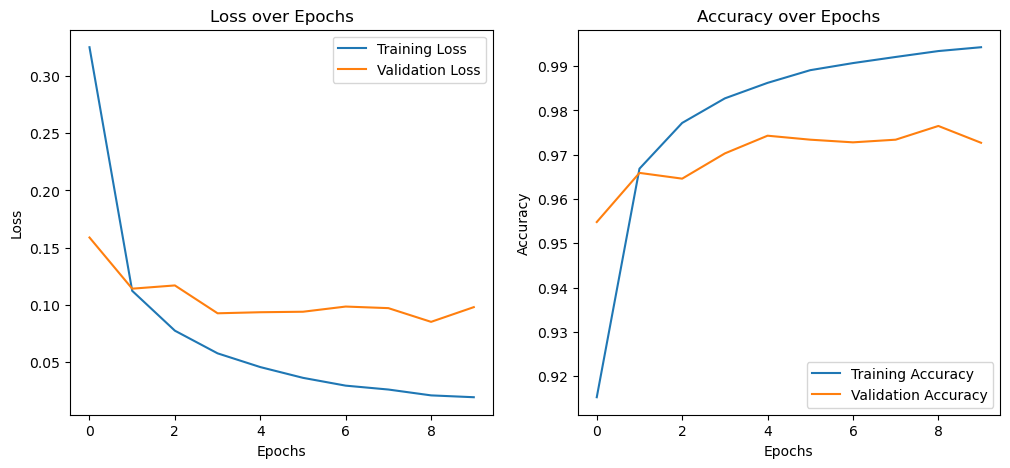

In [10]:
input_size = 784
hidden_sizes = [128, 64, 32] # ChatGPT suggested these neuron numbers
output_size = 10 

weights, biases = initialize_weights(input_size, hidden_sizes, output_size, init_method='xavier')

mini_batch_sgd(X_train, y_train, X_test, y_test, weights, biases, batch_size=100, learning_rate=0.001, epochs=10)


In [11]:
def hyperparameter_tuning(X_train, y_train, X_test, y_test, batch_size, epochs, learning_rates, initialization_methods):
    global biases_hidden_1, biases_hidden_2, biases_hidden_3, biases_output

    best_val_accuracy = 0
    best_hyperparams = {}

    for lr in learning_rates:
        for init_method in initialization_methods:
            print(f"Testing with learning rate: {lr}, initialization: {init_method}")

            if init_method == 'he':
                weights, biases = initialize_weights(input_size, hidden_sizes, output_size, init_method='he')
            elif init_method == 'xavier':
                weights, biases = initialize_weights(input_size, hidden_sizes, output_size, init_method='xavier')

            biases_hidden_1 = np.zeros(128)
            biases_hidden_2 = np.zeros(64)
            biases_hidden_3 = np.zeros(32)
            biases_output = np.zeros(10)

            mini_batch_sgd(X_train, y_train, X_test, y_test, weights, biases, batch_size, lr, epochs)

            # Compute test accuracy
            val_output, _, _, = forward_pass(X_test, weights, biases)
            val_one_hot = one_hot_encode(y_test)
            val_accuracy = compute_accuracy(val_output, val_one_hot)
            
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_hyperparams = {'learning_rate': lr, 'initialization': init_method}
                print(f"New best val accuracy!!: {val_accuracy*100:.2f}% with {best_hyperparams}")
    
    print(f"Best hyperparameters: {best_hyperparams}, Validation Accuracy: {best_val_accuracy*100:.2f}%")

Testing with learning rate: 0.0001, initialization: he
Epoch 1/15, Train Loss: 0.8076836323190162, Train Accuracy: 79.94%, Val Loss: 0.4177028243629932, Val Accuracy: 90.51%
Epoch 2/15, Train Loss: 0.33419097986113544, Train Accuracy: 91.85%, Val Loss: 0.28216095016704357, Val Accuracy: 93.07%
Epoch 3/15, Train Loss: 0.2413250350366216, Train Accuracy: 93.82%, Val Loss: 0.22399455651662625, Val Accuracy: 94.24%
Epoch 4/15, Train Loss: 0.1916463751794869, Train Accuracy: 95.02%, Val Loss: 0.1884895549897964, Val Accuracy: 95.01%
Epoch 5/15, Train Loss: 0.1589753861474574, Train Accuracy: 95.75%, Val Loss: 0.16444966462485205, Val Accuracy: 95.71%
Epoch 6/15, Train Loss: 0.13550735924800025, Train Accuracy: 96.35%, Val Loss: 0.14888206829506234, Val Accuracy: 95.86%
Epoch 7/15, Train Loss: 0.1174310686842299, Train Accuracy: 96.81%, Val Loss: 0.13931935483738936, Val Accuracy: 96.03%
Epoch 8/15, Train Loss: 0.103348307302328, Train Accuracy: 97.22%, Val Loss: 0.12704064582611238, Val Acc

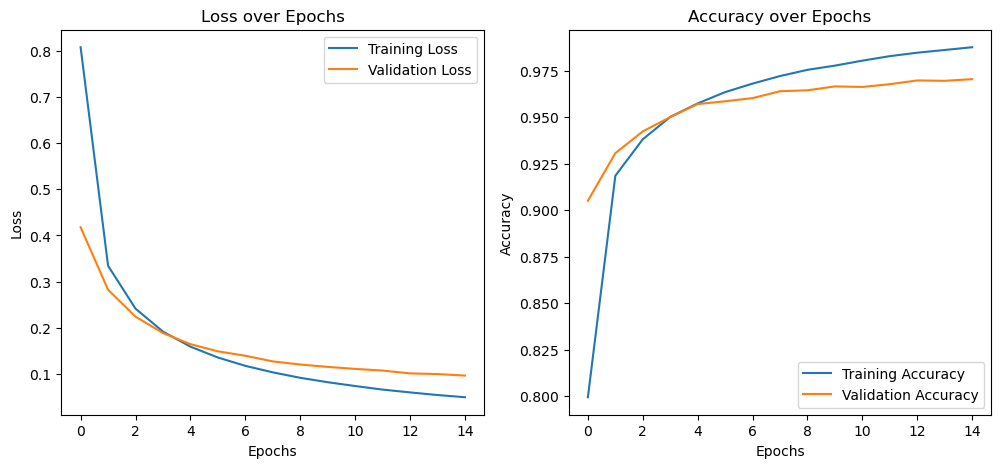

New best val accuracy!!: 97.05% with {'learning_rate': 0.0001, 'initialization': 'he'}
Testing with learning rate: 0.0001, initialization: xavier
Epoch 1/15, Train Loss: 0.9674801645978461, Train Accuracy: 78.93%, Val Loss: 0.5085857995765708, Val Accuracy: 89.67%
Epoch 2/15, Train Loss: 0.39625004701858313, Train Accuracy: 91.29%, Val Loss: 0.32645128593913003, Val Accuracy: 92.21%
Epoch 3/15, Train Loss: 0.27706258072764706, Train Accuracy: 93.19%, Val Loss: 0.2497352217263497, Val Accuracy: 93.64%
Epoch 4/15, Train Loss: 0.21846864256759352, Train Accuracy: 94.40%, Val Loss: 0.2093468028547241, Val Accuracy: 94.44%
Epoch 5/15, Train Loss: 0.18170017643560762, Train Accuracy: 95.17%, Val Loss: 0.18039199777095283, Val Accuracy: 95.25%
Epoch 6/15, Train Loss: 0.15477078449679602, Train Accuracy: 95.85%, Val Loss: 0.16160607939958752, Val Accuracy: 95.53%
Epoch 7/15, Train Loss: 0.13463086594178822, Train Accuracy: 96.32%, Val Loss: 0.14821855524844782, Val Accuracy: 95.78%
Epoch 8/15,

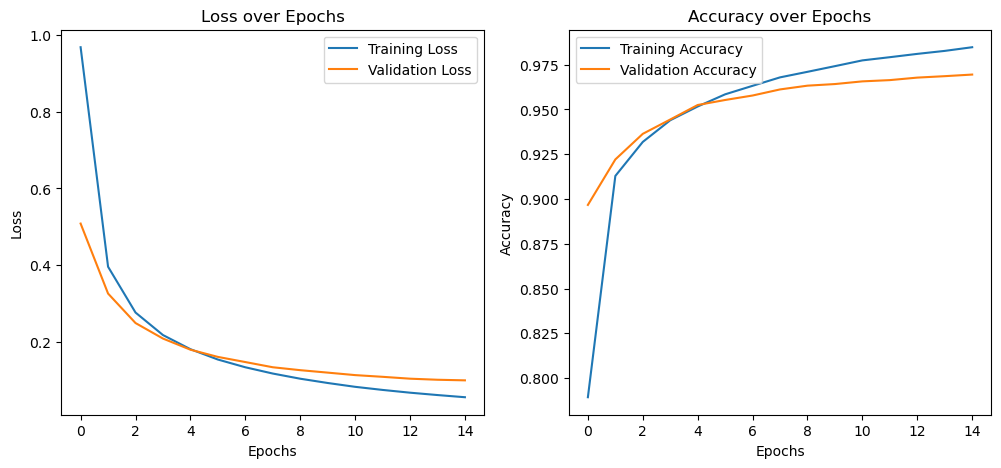

Testing with learning rate: 0.001, initialization: he
Epoch 1/15, Train Loss: 0.2943292431108042, Train Accuracy: 91.89%, Val Loss: 0.14915339700974073, Val Accuracy: 95.80%
Epoch 2/15, Train Loss: 0.11145737207067098, Train Accuracy: 96.74%, Val Loss: 0.11469045765200667, Val Accuracy: 96.71%
Epoch 3/15, Train Loss: 0.0754843994342069, Train Accuracy: 97.74%, Val Loss: 0.09505020223145097, Val Accuracy: 97.26%
Epoch 4/15, Train Loss: 0.05557726278108254, Train Accuracy: 98.34%, Val Loss: 0.0930088524471286, Val Accuracy: 97.16%
Epoch 5/15, Train Loss: 0.043522066279718635, Train Accuracy: 98.70%, Val Loss: 0.08786681029749163, Val Accuracy: 97.43%
Epoch 6/15, Train Loss: 0.03461805416983324, Train Accuracy: 98.94%, Val Loss: 0.10022503226089752, Val Accuracy: 96.86%
Epoch 7/15, Train Loss: 0.03069139472289261, Train Accuracy: 99.03%, Val Loss: 0.09207003476298531, Val Accuracy: 97.30%
Epoch 8/15, Train Loss: 0.02504200834393803, Train Accuracy: 99.22%, Val Loss: 0.08485785358589387, V

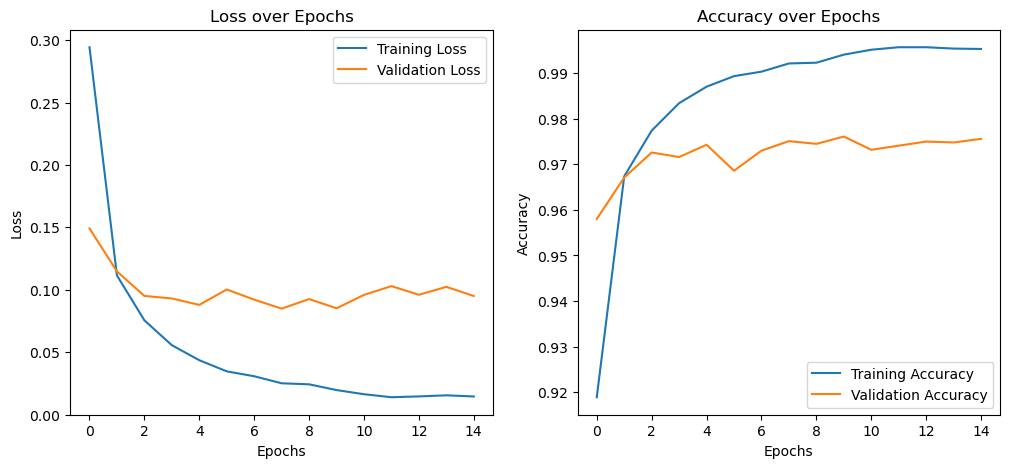

New best val accuracy!!: 97.56% with {'learning_rate': 0.001, 'initialization': 'he'}
Testing with learning rate: 0.001, initialization: xavier
Epoch 1/15, Train Loss: 0.31514879641421095, Train Accuracy: 91.83%, Val Loss: 0.16623851620618366, Val Accuracy: 95.14%
Epoch 2/15, Train Loss: 0.11261365929421419, Train Accuracy: 96.68%, Val Loss: 0.11097361972631552, Val Accuracy: 96.56%
Epoch 3/15, Train Loss: 0.07547772690450015, Train Accuracy: 97.74%, Val Loss: 0.11009513296911096, Val Accuracy: 96.63%
Epoch 4/15, Train Loss: 0.05646920754608584, Train Accuracy: 98.29%, Val Loss: 0.09708396564811636, Val Accuracy: 97.01%
Epoch 5/15, Train Loss: 0.044995160410873404, Train Accuracy: 98.64%, Val Loss: 0.08961421320066462, Val Accuracy: 97.51%
Epoch 6/15, Train Loss: 0.03580135429618485, Train Accuracy: 98.94%, Val Loss: 0.09199667797950928, Val Accuracy: 97.32%
Epoch 7/15, Train Loss: 0.02954394479739182, Train Accuracy: 99.12%, Val Loss: 0.08889691984285532, Val Accuracy: 97.45%
Epoch 8/

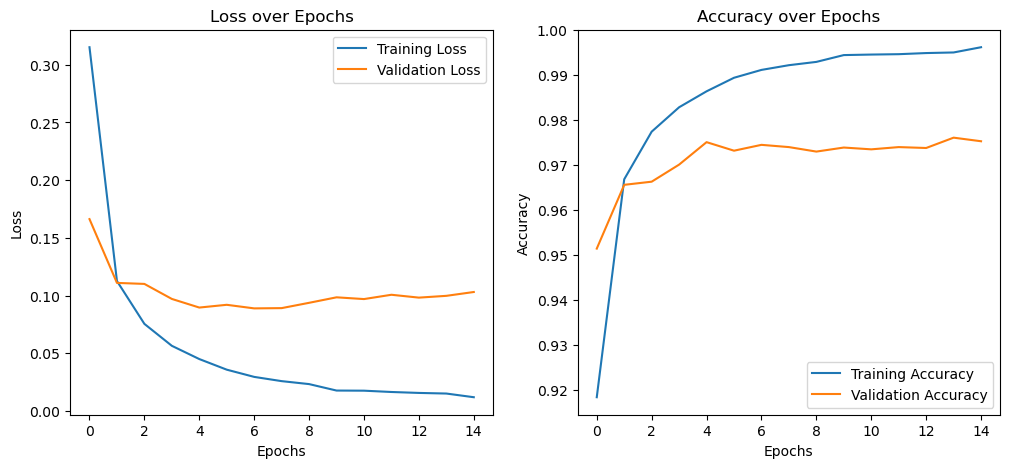

Testing with learning rate: 0.01, initialization: he
Epoch 1/15, Train Loss: 0.2862903286139864, Train Accuracy: 91.57%, Val Loss: 0.20281612956489675, Val Accuracy: 94.47%
Epoch 2/15, Train Loss: 0.19139341385402595, Train Accuracy: 94.60%, Val Loss: 0.19289736611611594, Val Accuracy: 94.59%
Epoch 3/15, Train Loss: 0.19903599673861105, Train Accuracy: 94.38%, Val Loss: 0.18668397495799435, Val Accuracy: 94.96%
Epoch 4/15, Train Loss: 0.2287319970544523, Train Accuracy: 93.69%, Val Loss: 0.2809458902857613, Val Accuracy: 92.26%
Epoch 5/15, Train Loss: 0.2928293695556556, Train Accuracy: 91.81%, Val Loss: 0.2639379296693752, Val Accuracy: 92.76%
Epoch 6/15, Train Loss: 0.2555148972518114, Train Accuracy: 93.03%, Val Loss: 0.28234100886450664, Val Accuracy: 92.37%
Epoch 7/15, Train Loss: 0.2779207437641641, Train Accuracy: 92.20%, Val Loss: 0.32852811869766085, Val Accuracy: 91.65%
Epoch 8/15, Train Loss: 0.3019644919307576, Train Accuracy: 91.52%, Val Loss: 0.3406146031544147, Val Accur

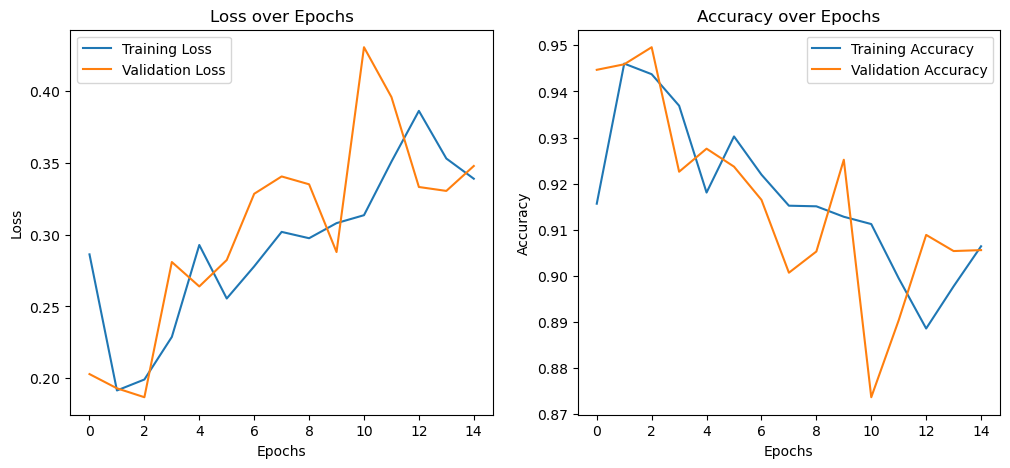

Testing with learning rate: 0.01, initialization: xavier
Epoch 1/15, Train Loss: 0.2817447294110479, Train Accuracy: 91.78%, Val Loss: 0.20837976897261118, Val Accuracy: 94.23%
Epoch 2/15, Train Loss: 0.1957521207358407, Train Accuracy: 94.61%, Val Loss: 0.24618587988286872, Val Accuracy: 93.23%
Epoch 3/15, Train Loss: 0.20771916785077013, Train Accuracy: 94.30%, Val Loss: 0.2306067781534418, Val Accuracy: 94.17%
Epoch 4/15, Train Loss: 0.21275431800561742, Train Accuracy: 94.31%, Val Loss: 0.2633846197982517, Val Accuracy: 92.96%
Epoch 5/15, Train Loss: 0.23243674335101053, Train Accuracy: 93.62%, Val Loss: 0.2560870423200857, Val Accuracy: 93.23%
Epoch 6/15, Train Loss: 0.252538362090372, Train Accuracy: 92.94%, Val Loss: 0.3754468561378318, Val Accuracy: 89.19%
Epoch 7/15, Train Loss: 0.27781269746238585, Train Accuracy: 92.27%, Val Loss: 0.2585583605369061, Val Accuracy: 93.21%
Epoch 8/15, Train Loss: 0.25455865415444884, Train Accuracy: 92.93%, Val Loss: 0.4212973692993207, Val Ac

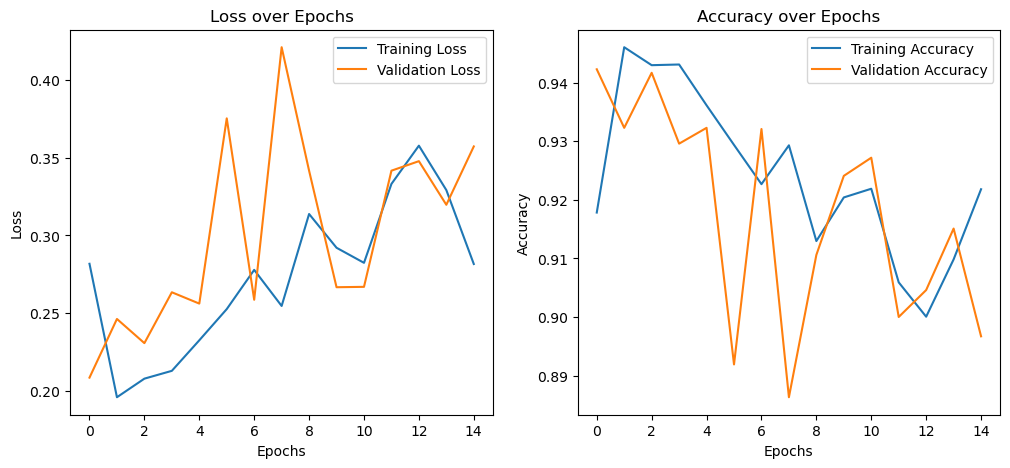

Best hyperparameters: {'learning_rate': 0.001, 'initialization': 'he'}, Validation Accuracy: 97.56%


In [13]:
hyperparameter_tuning(X_train, y_train, X_test, y_test, batch_size=100, epochs=15, learning_rates=[0.0001, 0.001, 0.01], initialization_methods=['he', 'xavier'])

Epoch 1/50, Train Loss: 0.33632568477049435, Train Accuracy: 90.74%, Val Loss: 0.1958667050962091, Val Accuracy: 94.41%
Epoch 2/50, Train Loss: 0.15480375135463917, Train Accuracy: 95.62%, Val Loss: 0.14619812970303764, Val Accuracy: 95.77%
Epoch 3/50, Train Loss: 0.10919168740828177, Train Accuracy: 96.88%, Val Loss: 0.12178704145166783, Val Accuracy: 96.48%
Epoch 4/50, Train Loss: 0.08389569076634579, Train Accuracy: 97.59%, Val Loss: 0.1092465695935357, Val Accuracy: 96.70%
Epoch 5/50, Train Loss: 0.06676408157088119, Train Accuracy: 98.01%, Val Loss: 0.10545710611752984, Val Accuracy: 96.96%
Epoch 6/50, Train Loss: 0.05498140472068659, Train Accuracy: 98.40%, Val Loss: 0.09511849046223404, Val Accuracy: 97.13%
Epoch 7/50, Train Loss: 0.04528550988217295, Train Accuracy: 98.68%, Val Loss: 0.09149286077880647, Val Accuracy: 97.14%
Epoch 8/50, Train Loss: 0.038869766953627344, Train Accuracy: 98.89%, Val Loss: 0.0876699683259467, Val Accuracy: 97.26%
Epoch 9/50, Train Loss: 0.03062907

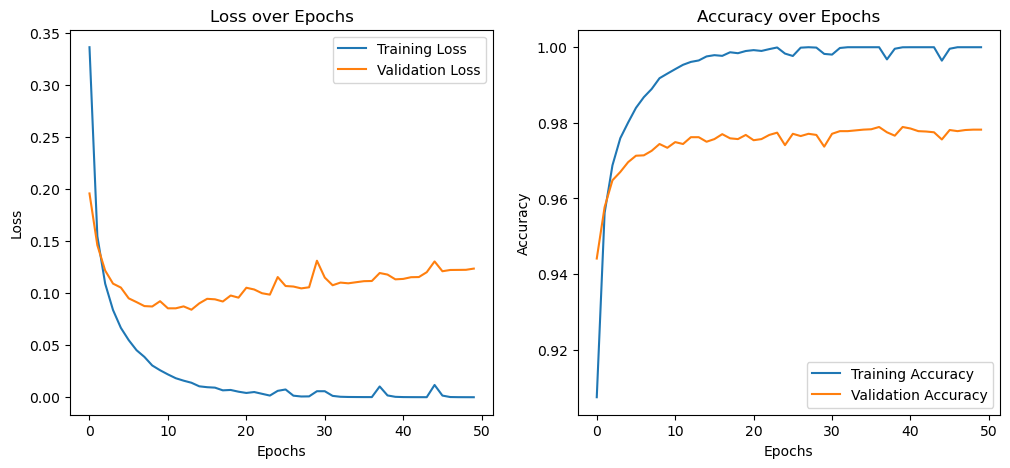

In [108]:
# Example for demonstrating overfitting
input_size = 784  
hidden_sizes = [128, 64, 32]
output_size = 10 

weights, biases = initialize_weights(input_size, hidden_sizes, output_size, init_method='he')

# Overfitting example with 100 epochs
mini_batch_sgd(X_train, y_train, X_test, y_test, weights, biases, batch_size=100, learning_rate=0.001, epochs=100)

# Explanation

I implemented a simple neural network with 3 hidden layers. The input has 784 features, which are the pixels of the image. Each hidden layer has 128, 64 and 32 neurons each (arbitrary numbers that ChatGPT recommended) since there was no required number, and the output has 10. I chose to implement ADAM as the optimizer. I trained the model for 10 epochs with a batch size of 128. After running hyperparameter tuning on the learning rate and weight initialization, I found that the optimal parameters were learning rate = 0.001 and weight initialization to be 'he' with an accuracy of 97.56%. I chose [0.0001, 0.001, 0.0.01] because when previously testing with 0.1, the loss exploded. I implemented the mini_batch_sgd function which prints out the loss and accuracy for each epoch. I also implemented the accuracy function which calculates the accuracy of the model. I originally incorrectly implemented the forward and backpropagation functions with only the ReLU activation function to facilitate flexibility in the amount of hidden layers such that my overfitting example could have only 1 hidden layer. There, the model started overfitting at around 34 epochs when the training accuracy reached 100%. After correcting the forward and backpropagation functions to use ReLU, SELU and tanh, I reran the overfitting example and it similarly reached 100% training accuracy at the 34th epoch, displaying overfitting.